In [1]:
import sys
import os
sys.path.append('../src/')
from vega_model import VEGA
from utils import *
import torch
torch.manual_seed(0)
np.random.seed(0)
import pandas as pd
import umap
import scanpy as sc
import numpy as np
import itertools
#import MulticoreTSNE
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['axes.linewidth'] = .5
matplotlib.rcParams['lines.linewidth'] = .5
matplotlib.rcParams['patch.linewidth'] = .5
import seaborn as sns
# Reload data
adata_train = sc.read('../data/wk02_af_hvg.h5ad')
# Reload pathway
pathway_dict = read_gmt('../data/reactomes_organoid_ct.gmt')
n = 1
pathway_list = list(pathway_dict.keys())+['UNANNOTATED_'+str(k) for k in range(n)]
pathway_mask = create_pathway_mask(adata_train.var.index.tolist(), pathway_dict, add_missing=n, fully_connected=True)

In [ ]:
# Read results npy
res = np.load('../trained_models/organoid/10CV_vega_organoid.npy', allow_pickle=True).item()
best_f = 0
best_l = 99999
for k,v in res.items():
    l = v['best_valid_loss']
    print(k, l)
    if l < best_l:
        best_f = k
        best_l = l

In [ ]:
vae = VEGA(pathway_mask=pathway_mask, positive_decoder=True)
vae.load_state_dict(torch.load('../trained_models/organoid/vega_organoid_fold_%s.pt'%(best_f), map_location=torch.device('cpu')))
# Set to eval
vae.eval()

In [4]:
z = vae.to_latent(torch.Tensor(adata_train.X.A)).detach().numpy()
pathway_encoded_df = pd.DataFrame(data=z, index=adata_train.obs.index.tolist(), columns=pathway_list)

In [5]:
reducer = umap.UMAP(random_state=42, min_dist=0.5, n_neighbors=15)
embedding = reducer.fit_transform(z)

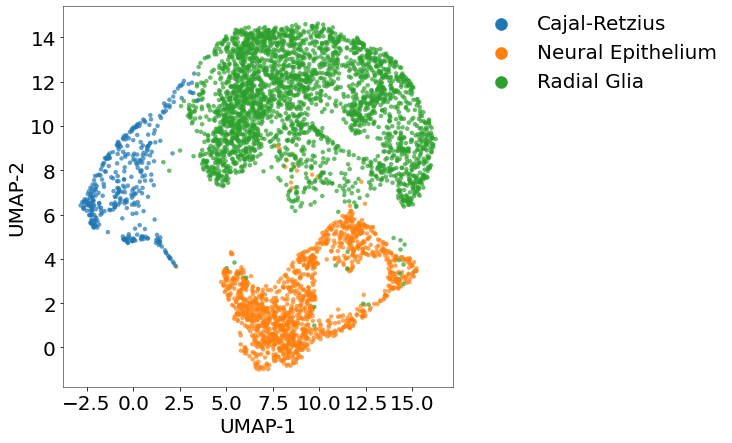

In [6]:
umap_df = pd.DataFrame({'UMAP-1':embedding[:,0], 'UMAP-2':embedding[:,1],
                        'Cell Type':adata_train.obs['Cell type']})
plt.figure(figsize=[7,7])
sns.scatterplot(x='UMAP-1', y='UMAP-2', hue='Cell Type', data=umap_df,
                linewidth=0, alpha=0.7, s=20)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=20, frameon=False, markerscale=2)
#plt.legend(frameon=False, ncol=1, fontsize=13, markerscale=1.5)
plt.xlabel('UMAP-1', fontsize=20)
plt.ylabel('UMAP-2', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

#plt.savefig('../paper/figures/fig3-organoid-ct.pdf', format='pdf', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

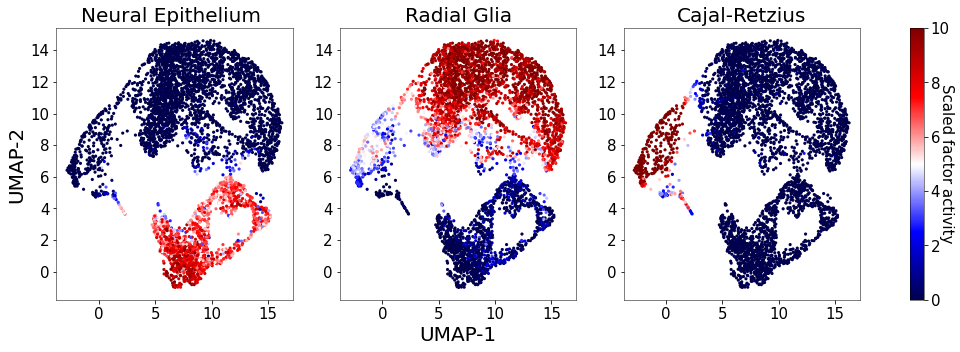

In [7]:
from matplotlib.colors import Normalize
import matplotlib.cm as cm

fig, ax = plt.subplots(1,3, figsize=[18,5])
ct = ['Neuroepithelium ', 'Radial Glia Cells', 'Cajal-Retzius Neurons']
lbl = ['Neural Epithelium ', 'Radial Glia', 'Cajal-Retzius']
cmap = cm.get_cmap('seismic')
normalizer=Normalize(0,10)
im=cm.ScalarMappable(norm=normalizer)

for i in range(len(ct)):
    im = ax[i].scatter(embedding[:,0], embedding[:,1], alpha = 1, linewidths=0,
                c = pathway_encoded_df[ct[i]], marker='o', s=10, cmap =cmap, norm=normalizer)
    ax[i].set_title(lbl[i], fontsize=20)
    if i==0:
        ax[i].set_ylabel('UMAP-2', fontsize=20)
    else:
        ax[i].set_ylabel('')
    if i==1:
        ax[i].set_xlabel('UMAP-1', fontsize=20)
    else:
        ax[i].set_xlabel('', fontsize=20)
    ax[i].yaxis.set_tick_params(labelsize=15)
    ax[i].xaxis.set_tick_params(labelsize=15)
        
cbar = fig.colorbar(im, ax=ax.ravel().tolist())
cbar.ax.set_ylabel('Scaled factor activity', rotation=270, fontsize=15)
cbar.ax.tick_params(labelsize=15)
#plt.savefig('../paper/figures/fig3-organoid-activity.pdf', format='pdf', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

In [8]:
dict_de = {}
for ct in adata_train.obs['Cell type'].unique():
    print('DFE for ',ct)
    adata_ct = adata_train[np.array([ct==c for c in adata_train.obs['Cell type']]),:].copy()
    adata_ct.X = adata_ct.X.A
    adata_rest = adata_train[~np.array([ct==c for c in adata_train.obs['Cell type']]),:].copy()
    adata_rest.X = adata_rest.X.A
    dfe_res = vae.bayesian_diff_exp(adata_ct, adata_rest, n_samples=5000,
                                   use_permutations=True, n_permutations=10000, random_seed=0)
    dict_de[ct] = dfe_res

DFE for  Radial Glia


/home/ubuntu/anaconda3/envs/torch_env/lib/python3.6/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


DFE for  Neural Epithelium
DFE for  Cajal-Retzius


In [9]:
mat_bf = np.zeros((3,3))
ct_list = list(adata_train.obs['Cell type'].unique())
ct_list.sort()
lbl = ['Neuroepithelium ', 'Radial Glia Cells', 'Cajal-Retzius Neurons']
map_lbl = {'Neuroepithelium ':'Neural Epithelium', 'Radial Glia Cells':'Radial Glia', 'Cajal-Retzius Neurons':'Cajal-Retzius'}
new_lbl = [map_lbl[i] for i in lbl]
lbl.sort()
new_lbl.sort()
for i, ct_1 in enumerate(ct_list):
    for j, ct_2 in enumerate(lbl):
        mat_bf[i,j] = dict_de[ct_1]['bayes_factor'][pathway_list.index(ct_2)]

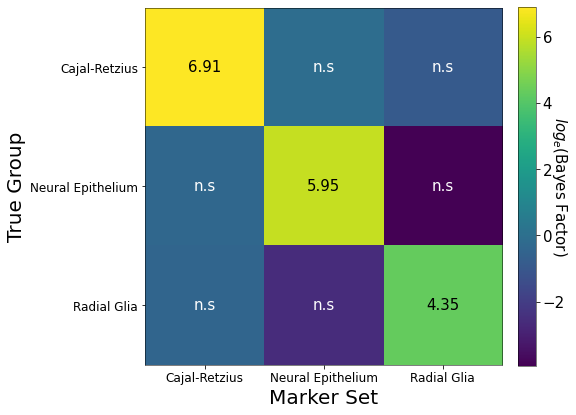

In [10]:
plt.figure(figsize=[7,7])
im = plt.imshow(mat_bf)
cbar = plt.colorbar(im,fraction=0.046, pad=0.04)
cbar.ax.set_ylabel(r'$log_e$(Bayes Factor)', rotation=270, fontsize=15)
cbar.ax.tick_params(labelsize=15)
plt.xticks([0,1,2], new_lbl, fontsize=12)
plt.yticks([0,1,2], ct_list, fontsize=12)
for (j,i),label in np.ndenumerate(mat_bf):
    c = 'white' if label < 0 else 'black'
    label = label if label > 3 else 'n.s'
    if type(label) != str:
        label = '%.2f'%(label)
    plt.text(i,j,label,ha='center',va='center', fontsize=15, color=c)

plt.xlabel('Marker Set', fontsize=20)
plt.ylabel('True Group', fontsize=20)
#plt.savefig('../paper/figures/organoid/fig3-organoid-heatmap.pdf', format='pdf', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

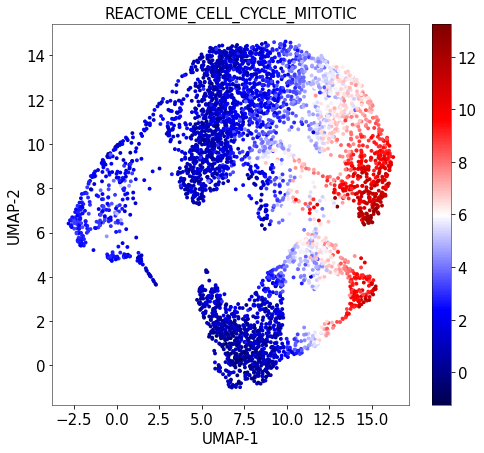

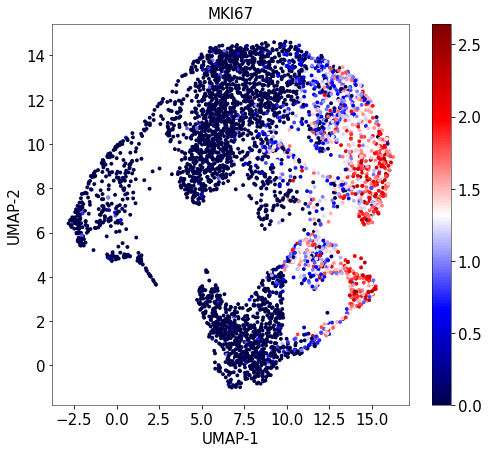

In [11]:
fig = plt.figure(figsize=[8,7])
plt.scatter(embedding[:,0], embedding[:,1], alpha = 1, linewidths=0,
                c = pathway_encoded_df['REACTOME_CELL_CYCLE_MITOTIC'], marker='o', s=15, cmap ='seismic')
plt.title('REACTOME_CELL_CYCLE_MITOTIC', fontsize=15)
cbar = plt.colorbar()
for t in cbar.ax.get_yticklabels():
     t.set_fontsize(15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('UMAP-1', fontsize=15)
plt.ylabel('UMAP-2', fontsize=15)
#plt.savefig('../paper/figures/organoid/fig3-organoid-mitotic.pdf', format='pdf', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

fig = plt.figure(figsize=[8,7])
plt.scatter(embedding[:,0], embedding[:,1], alpha = 1, linewidths=0,
                c = adata_train.X.A[:,adata_train.var.index.tolist().index('MKI67')], marker='o', s=15, cmap ='seismic')
plt.title('MKI67', fontsize=15)
cbar = plt.colorbar()
for t in cbar.ax.get_yticklabels():
     t.set_fontsize(15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('UMAP-1', fontsize=15)
plt.ylabel('UMAP-2', fontsize=15)
#plt.savefig('../paper/figures/organoid/fig3-organoid-mki67.pdf', format='pdf', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

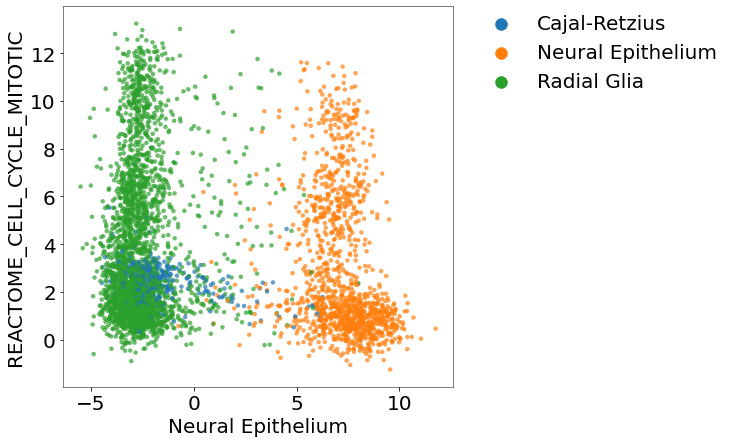

In [12]:
fig=plt.figure(figsize=[7,7])
sns.scatterplot(x=pathway_encoded_df['Neuroepithelium '],
            y=pathway_encoded_df['REACTOME_CELL_CYCLE_MITOTIC'],
            hue=adata_train.obs['Cell type'],
           linewidth=0, alpha=0.7, s=20)
plt.ylabel('REACTOME_CELL_CYCLE_MITOTIC',fontsize=20)
plt.xlabel('Neural Epithelium',fontsize=20)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=20, frameon=False, markerscale=2)
plt.tick_params(labelsize=20)
#plt.savefig('../paper/figures/organoid/fig3-organoid-bivar-div.pdf', format='pdf', dpi=300, bbox_inches='tight')

/home/ubuntu/anaconda3/envs/torch_env/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


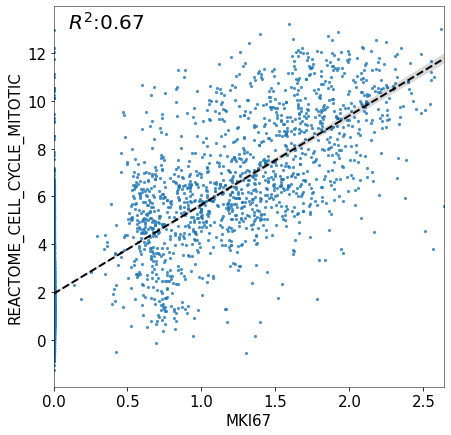

In [13]:
from scipy.stats import linregress
fig = plt.figure(figsize=[7,7])
r_pearson = linregress(adata_train.X.A[:,adata_train.var.index.tolist().index('MKI67')], pathway_encoded_df['REACTOME_CELL_CYCLE_MITOTIC'])[2]
sns.regplot(adata_train.X.A[:,adata_train.var.index.tolist().index('MKI67')],
            pathway_encoded_df['REACTOME_CELL_CYCLE_MITOTIC'],
           line_kws={"linewidth": 2, 'color':'k', 'linestyle':'--'},
           scatter_kws={'s':10, 'linewidth':0})

plt.text(0.1, 13, r'$R^2$:%.2f'%(r_pearson**2), fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('MKI67', fontsize=15)
plt.ylabel('REACTOME_CELL_CYCLE_MITOTIC', fontsize=15)
#plt.savefig('../paper/figures/organoid/fig3-organoid-regplot.pdf', format='pdf', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

In [14]:
# MKI67 as external validator of dividing cells
'MKI67' in pathway_dict['REACTOME_CELL_CYCLE_MITOTIC']

False

## Supplementary figures for organoid analysis

In [119]:
# Save top 50 DA factors for each cell type
dict_top50 = {(i,j):[] for i in map_lbl.values() for j in ['name','logBF']}
for k in dict_top50.keys():
    ct = k[0]
    t = k[1]
    s_idx = np.argsort(np.abs(dict_de[ct]['bayes_factor']))[::-1][:50]
    if t=='logBF':
        dict_top50[k] = dict_de[ct]['bayes_factor'][s_idx]
    else:
        names = np.array(pathway_list)[s_idx]
        for orig_ct in map_lbl.keys():
            if np.where(names==orig_ct)[0].size != 0:
                idx = np.where(names==orig_ct)[0][0]
                names[idx] = map_lbl[orig_ct]
        dict_top50[k] = names
df_top50 = pd.DataFrame(dict_top50)
df_top50.to_csv('../paper/suppTable_top50DF_organoid.csv', sep=',', index=True, header=True)